This graph shows the perils of using t values to perform model selection. We create a situation such that the d (treatment) variable in fact has no impact on y, but it is correlated with x. Because of this correlation, we end up rejecting the null hypothesis that $\alpha = 0$ much more than 5% of the time (~30% of the time, in these simulations), at 5% significance.

$$ y_i = d_i \alpha + x_i \beta + \epsilon_i $$

$$ \alpha = 0, \beta = 0.2 $$

$$ (d_i, x_i) \sim N(0, \begin{bmatrix}1 & .8 \\ .8 & 1\end{bmatrix}) $$

> we drop x if we do not reject the null that beta's equal to zero (95% chance of that) ignoring the fact that you did the model selection when you do the final inference on alpha - remarks from Denzil Fiebig

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats

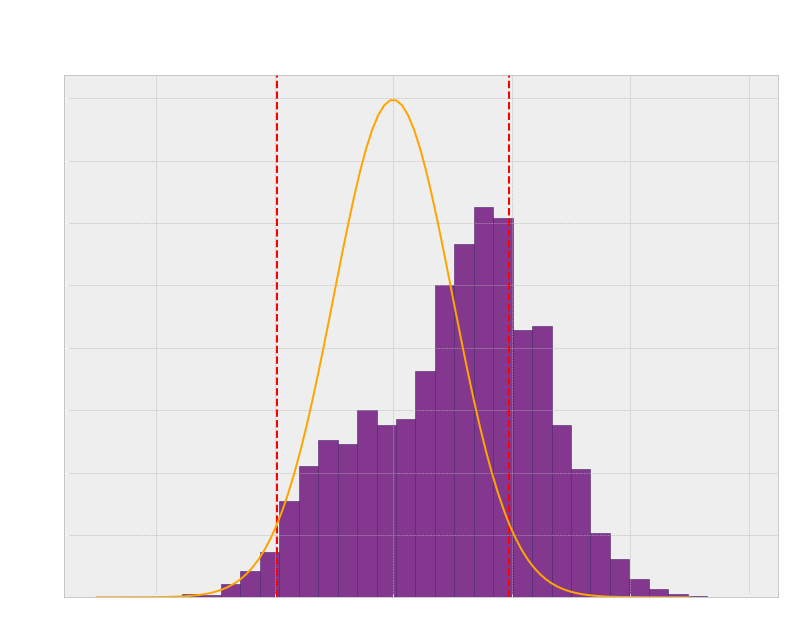

In [4]:
alpha_hat_list = []
num_of_iterations = 5000

for i in range(num_of_iterations):
    n = 100
    d, x = np.random.multivariate_normal([0, 0], [[1, 0.8], [0.8, 1]], n).T
    e = np.random.normal(loc=0, scale=1, size=n)
    y = x*0.2 + e
    
    X = np.column_stack((d, x))
    
    results = sm.OLS(y, X).fit()
    
    # coefficient on the treatment we are interested in
    alpha_hat = results.params[0]
    alpha_se = results.bse[0]
    t_alpha = alpha_hat/alpha_se

    # coefficient on a feature we are considering including in the model
    beta_hat = results.params[1]
    beta_se = results.bse[1]
    t_beta = beta_hat/beta_se

    # if beta insignificant at 5%, perform another regression without it
    if -1.96 < t_beta < 1.96:
        results2 = sm.OLS(y, d).fit()
        
        alpha_hat2 = results2.params[0]
        alpha_se2 = results2.bse[0]
        t_alpha2 = alpha_hat2/alpha_se2

        alpha_hat_list.append(t_alpha2)

    # if beta is significant at 5%, then we use alpha as is
    else:
        alpha_hat_list.append(t_alpha)

crit_val = 1.96
proportion_rejected = sum([i < -crit_val or i > crit_val for i in alpha_hat_list]) / num_of_iterations

COLOR='w'
with plt.style.context('bmh'):
    fig, ax = plt.subplots()
    fig.suptitle(f'Distribution of t = α̂/se(α̂)\n{100*proportion_rejected:.2f}% rejected at 5%',
                 fontsize=24,
                 color=COLOR)
    ax.axvline(-1.96, c="red", linestyle="--"); ax.axvline(1.96, c="red", linestyle="--")
    ax.hist(alpha_hat_list, bins=30, edgecolor="#401a61", color="#84378e", density=True)

    domain = np.linspace(-5, 5, 100)
    ax.plot(domain, [scipy.stats.norm.pdf(x, 0, 1) for x in domain], color="orange")
    
    SIZE=24
    ax.tick_params(axis='x', colors=COLOR, labelsize=SIZE)
    ax.tick_params(axis='y', colors=COLOR, labelsize=SIZE)

# Generating multivariate normal dists in R

```r
# Functions and datasets to support Venables and Ripley, "Modern Applied Statistics with S"
install.packages("MASS")
library(MASS)
X_MASS <- mvrnorm(100, c(0,0), matrix(c(1, 0.8, 0.8, 1), nrow=2, ncol=2))


# Multivariate Normal and t Distributions.
install.packages("mvtnorm")
library(mvtnorm)
sigma <- matrix(c(1, 0.8, 0.8, 1), nrow = 2)
X_mvtnorm <- rmvnorm(100, mean = c(0, 0), sigma = sigma, method="chol")


# manually, https://stats.stackexchange.com/a/38867
# by user 'gung - Reinstate Monica' on StackOverflow
correlatedValue = function(x, r){
    r2 = r**2
    ve = 1-r2
    SD = sqrt(ve)
    e  = rnorm(length(x), mean=0, sd=SD)
    y  = r*x + e
    return(y)
}
x = rnorm(100); y = correlatedValue(x=x, r=.8)
X_gungSO = cbind(x, y)


# compare the 3 ways
# mfrow simply stands for "MultiFrame rowwise layout"
par(mfrow=c(1, 3)); plot(X_MASS); plot(X_mvtnorm); plot(X_gungSO)

# create the vectors
d <- X_MASS[,1]
x <- X_MASS[,2]
y <- 0.2*x + rnorm(100)
```